In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import kerastuner as kt
import IPython
import tensorflow_addons as tfa

%run "../AI_Medicine/Custom Loss and Custom Metric.ipynb"

In [2]:
train_df = pd.read_csv('../data/lish-moa/train_features.csv')
train_labels = pd.read_csv('../data/lish-moa/train_targets_scored.csv')

In [3]:
train_df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
# Removing unwanted column
train_df.pop('sig_id')
train_labels.pop('sig_id')


0        id_000644bb2
1        id_000779bfc
2        id_000a6266a
3        id_0015fd391
4        id_001626bd3
             ...     
23809    id_fffb1ceed
23810    id_fffb70c0c
23811    id_fffc1c3f4
23812    id_fffcb9e7c
23813    id_ffffdd77b
Name: sig_id, Length: 23814, dtype: object

In [5]:
np.array(train_labels.sum(axis = 0))

array([ 17,  18,  24, 190, 301,  73,  54,  96,  12, 270, 360,  66,   7,
        42,  12,  12,  48,  89,  80,  36,  37,  73,   6,  43,  12,  13,
        12,  18,  73,  36,  23,  49,  47,   6,   1,  12,  97,  19,  96,
         6,  60,  80,  36, 192,  89, 115,   7,  31,  38,  67,  24,  68,
        29,   6, 281,  42,  55,  36,  36,  18,  12, 102,  18, 340,  54,
        24,  42,  48,  54,   6,  36, 435, 104,  36,  25,   6,  48, 402,
       121, 424, 336,   6,   1, 158,  48,  36,  18,  25,  50, 279,  18,
        18,  23, 106, 165,  56, 266,  13,  74, 367,  18,  60,  72, 106,
        59, 241,  24,  32,  72, 283,  93,  37,  30,  31,  73,  30,  51,
        42,  92, 273,   6,   6,  62,  12,  61,   6,  31,  72,  74,  25,
        12,  85,  18, 130,  48,  37, 832,   6,  26,  12,  26,   7,  18,
        61,  96,  37,  62,  24,  61, 297,  18, 264,  25, 151,  31,  55,
        98, 115,  30, 119,  18,  36,  84, 726,  48,   6, 103,  19,  56,
       223,  12,  67,   6,  35,  37,  25, 236, 404,  44,  36,  3

In [6]:
# Handling String features
cp_dose_mapping = {'D1':0, 'D2':1}
train_df['cp_dose'] = train_df['cp_dose'].apply(lambda x: cp_dose_mapping[x])

cp_type_mapping = {'ctl_vehicle':0, 'trt_cp':1}
train_df['cp_type'] = train_df['cp_type'].apply(lambda x: cp_type_mapping[x])

In [7]:
# Handling Categorical features
cp_time_mapping = {24:0, 48:1, 72:2}
train_df['cp_time'] = train_df['cp_time'].apply(lambda x: cp_time_mapping[x])

In [8]:
train_df.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [9]:
# Standardize the Data

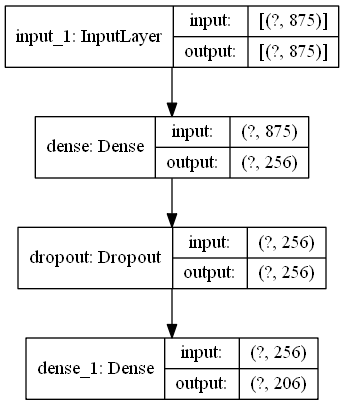

In [10]:
def create_model():
    input1 = tf.keras.layers.Input(shape=(875))
    dense1 = tf.keras.layers.Dense(units = 256, activation = 'relu')(input1)
    dropout1 = tf.keras.layers.Dropout(0.2)(dense1)
    output1 = tf.keras.layers.Dense(units = 206, activation = 'sigmoid')(dropout1)
    
    model = tf.keras.Model(inputs = input1, outputs = output1)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2), loss='binary_crossentropy', metrics = ['accuracy', tfa.metrics.F1Score(206, average = 'macro')])
    return model

model = create_model()
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [11]:
CALLBACKS = []
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f1_score', patience = 100)
save_model = tf.keras.callbacks.ModelCheckpoint('best_model.h5',monitor = 'val_f1_score', save_best_only=True)
CALLBACKS.append(save_model)
CALLBACKS.append(early_stopping)

In [16]:
model = tf.keras.models.load_model('best_model.h5')
history = model.fit(x = train_df, y = train_labels, batch_size=1024, epochs = 10000, validation_split= 0.3, callbacks=CALLBACKS, verbose = 2)

Epoch 1/10000
17/17 - 1s - loss: 0.0456 - accuracy: 0.0836 - f1_score: 0.0316 - val_loss: 0.0286 - val_accuracy: 0.0890 - val_f1_score: 0.0381
Epoch 2/10000
17/17 - 0s - loss: 0.0232 - accuracy: 0.1070 - f1_score: 0.0445 - val_loss: 0.0212 - val_accuracy: 0.1022 - val_f1_score: 0.0480
Epoch 3/10000
17/17 - 0s - loss: 0.0186 - accuracy: 0.1250 - f1_score: 0.0566 - val_loss: 0.0190 - val_accuracy: 0.1016 - val_f1_score: 0.0523
Epoch 4/10000
17/17 - 0s - loss: 0.0166 - accuracy: 0.1305 - f1_score: 0.0728 - val_loss: 0.0182 - val_accuracy: 0.1107 - val_f1_score: 0.0645
Epoch 5/10000
17/17 - 0s - loss: 0.0153 - accuracy: 0.1500 - f1_score: 0.0927 - val_loss: 0.0177 - val_accuracy: 0.1152 - val_f1_score: 0.0760
Epoch 6/10000
17/17 - 0s - loss: 0.0144 - accuracy: 0.1667 - f1_score: 0.1209 - val_loss: 0.0175 - val_accuracy: 0.1164 - val_f1_score: 0.0818
Epoch 7/10000
17/17 - 0s - loss: 0.0136 - accuracy: 0.1862 - f1_score: 0.1407 - val_loss: 0.0173 - val_accuracy: 0.1176 - val_f1_score: 0.0850

Epoch 58/10000
17/17 - 0s - loss: 0.0011 - accuracy: 0.5636 - f1_score: 0.6830 - val_loss: 0.0379 - val_accuracy: 0.1443 - val_f1_score: 0.1180
Epoch 59/10000
17/17 - 0s - loss: 0.0010 - accuracy: 0.5640 - f1_score: 0.6772 - val_loss: 0.0381 - val_accuracy: 0.1348 - val_f1_score: 0.1165
Epoch 60/10000
17/17 - 0s - loss: 0.0011 - accuracy: 0.5626 - f1_score: 0.6812 - val_loss: 0.0386 - val_accuracy: 0.1486 - val_f1_score: 0.1179
Epoch 61/10000
17/17 - 0s - loss: 0.0010 - accuracy: 0.5645 - f1_score: 0.6805 - val_loss: 0.0389 - val_accuracy: 0.1428 - val_f1_score: 0.1145
Epoch 62/10000
17/17 - 0s - loss: 0.0010 - accuracy: 0.5660 - f1_score: 0.6775 - val_loss: 0.0395 - val_accuracy: 0.1432 - val_f1_score: 0.1162
Epoch 63/10000
17/17 - 0s - loss: 0.0010 - accuracy: 0.5659 - f1_score: 0.6821 - val_loss: 0.0397 - val_accuracy: 0.1327 - val_f1_score: 0.1161
Epoch 64/10000
17/17 - 0s - loss: 9.6510e-04 - accuracy: 0.5679 - f1_score: 0.6771 - val_loss: 0.0400 - val_accuracy: 0.1433 - val_f1_sc

In [13]:
# model1 = tf.keras.models.load_model('best_model.h5')


In [14]:
# tfa.metrics.F1Score(206, average = 'macro')